In [1]:
''' import '''
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

plt.rc('font', family='Malgun Gothic') # For Windows
print(plt.rcParams['font.family'])
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import FinanceDataReader as fdr

['Malgun Gothic']


In [8]:
''' data load '''
df_train = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')
train = df_train.copy()
test = df_test.copy()
df_building = pd.read_csv('../data/building_info.csv')
df_sub = pd.read_csv('../data/sample_submission.csv')

' data load '

In [9]:
''' date&hour '''
train['datehour'] = pd.to_datetime(train['일시'].str.replace(' ', ''), format='%Y%m%d%H')
test['datehour'] = pd.to_datetime(test['일시'].str.replace(' ', ''), format='%Y%m%d%H')
train['hour'] = train['datehour'].dt.hour
test['hour'] = test['datehour'].dt.hour
train['date'] = pd.to_datetime(train['일시'].str.slice(0, 8), format='%Y%m%d')
test['date'] = pd.to_datetime(test['일시'].str.slice(0, 8), format='%Y%m%d')
train = train.drop(['일시', 'num_date_time'], axis=1)
test = test.drop(['일시', 'num_date_time'], axis=1)
train['dayofweek'] = train['date'].dt.dayofweek
test['dayofweek'] = test['date'].dt.dayofweek

' date&hour '

In [10]:
''' merge building_info.csv '''
train = train.merge(df_building, on='건물번호')
test = test.merge(df_building, on='건물번호')
train['건물번호'] = train['건물번호'].astype('category')
train['건물유형'] = train['건물유형'].astype('category')
test['건물번호'] = test['건물번호'].astype('category')
test['건물유형'] = test['건물유형'].astype('category')

' merge building_info.csv '

# 건물유형 별 EDA

In [14]:
def graph_by_btypes(btype):
    building_nums = train.loc[train['건물유형'] == btype, '건물번호'].unique()
    fig, ax = plt.subplots(nrows=len(building_nums), figsize=(20, 3*len(building_nums)))
    for i, building_num in enumerate(building_nums):
        _ = ax[i].set_title(f'{btype} {building_num}')
        _ = sns.lineplot(data=train.loc[train['건물번호'] == building_num], y='전력소비량(kWh)', x='datehour', color='b', ax=ax[i])

### 공공

- 공휴일(holiday)에 전력소비량이 눈에 띄게 낮아짐 (16번 건물 제외)
- 일별 전력소비량 최대값이 기온/불쾌지수의 일별 평균/최대값 추세를 따름

- 이상치
    - 17번 건물
        - 7월 22~23일 : 위아래로 튀는 데이터 부자연스러움
    - 21번 건물
        - 7월 1일 : 유일하게 공휴일이 아닌 평일 전력소비량이 반토막 남

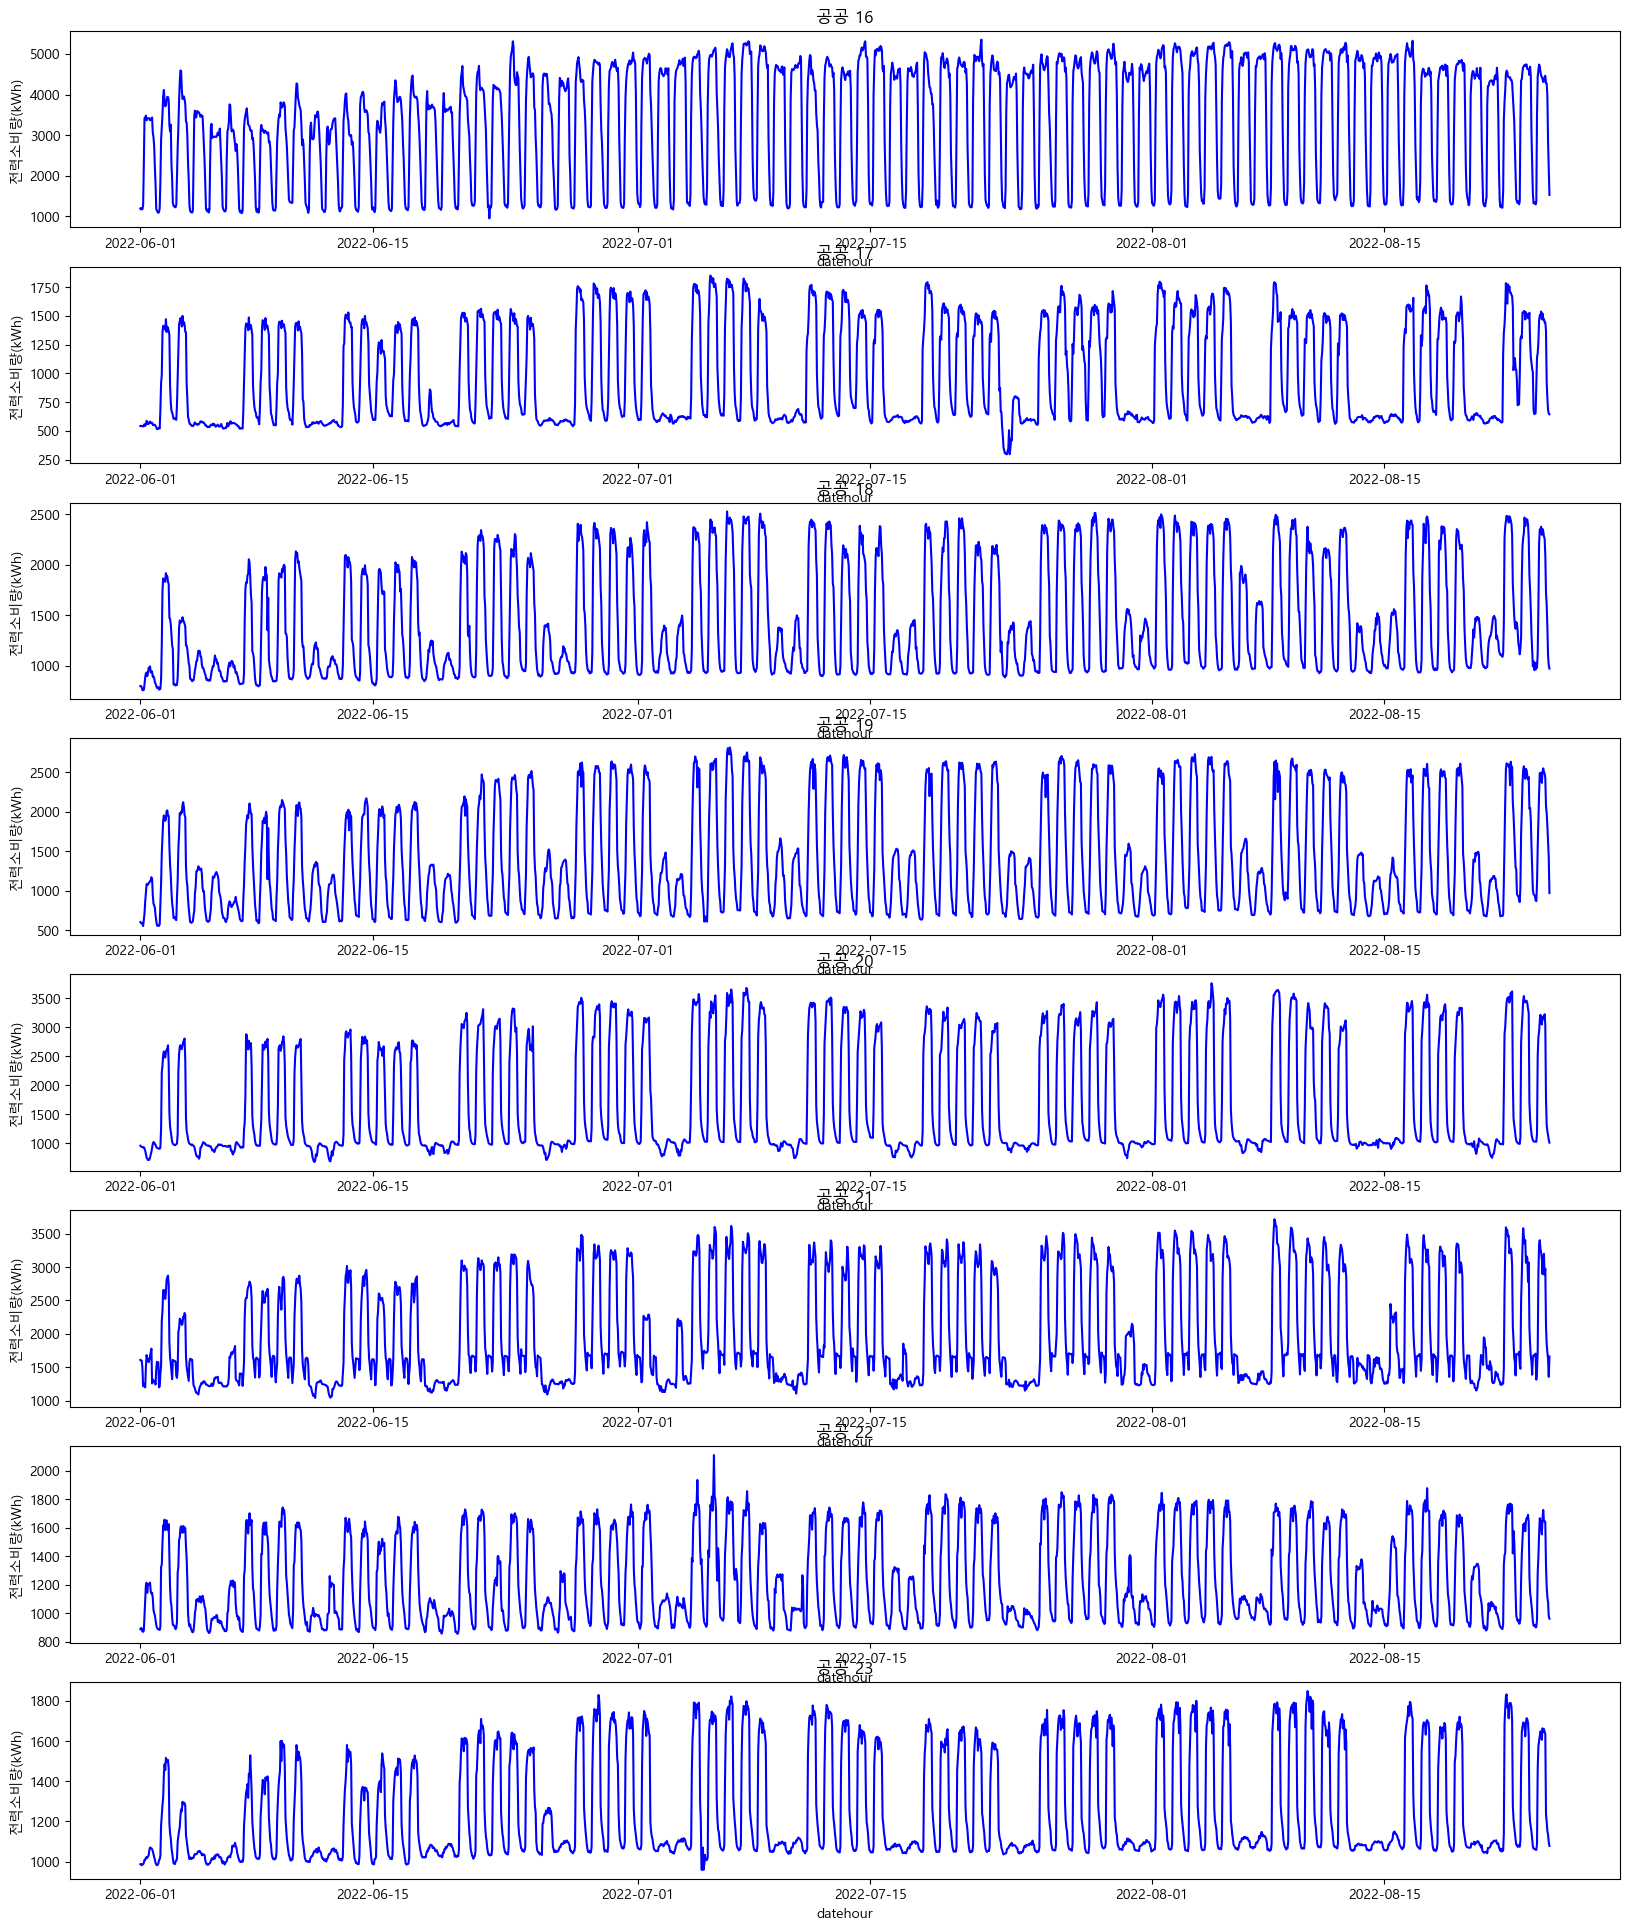

In [15]:
graph_by_btypes('공공')

### 대학교

- 공휴일(holiday)에 전력소비량이 눈에 띄게 낮아짐
- 일별 전력소비량 최대값이 기온/불쾌지수의 일별 평균/최대값 추세를 따름

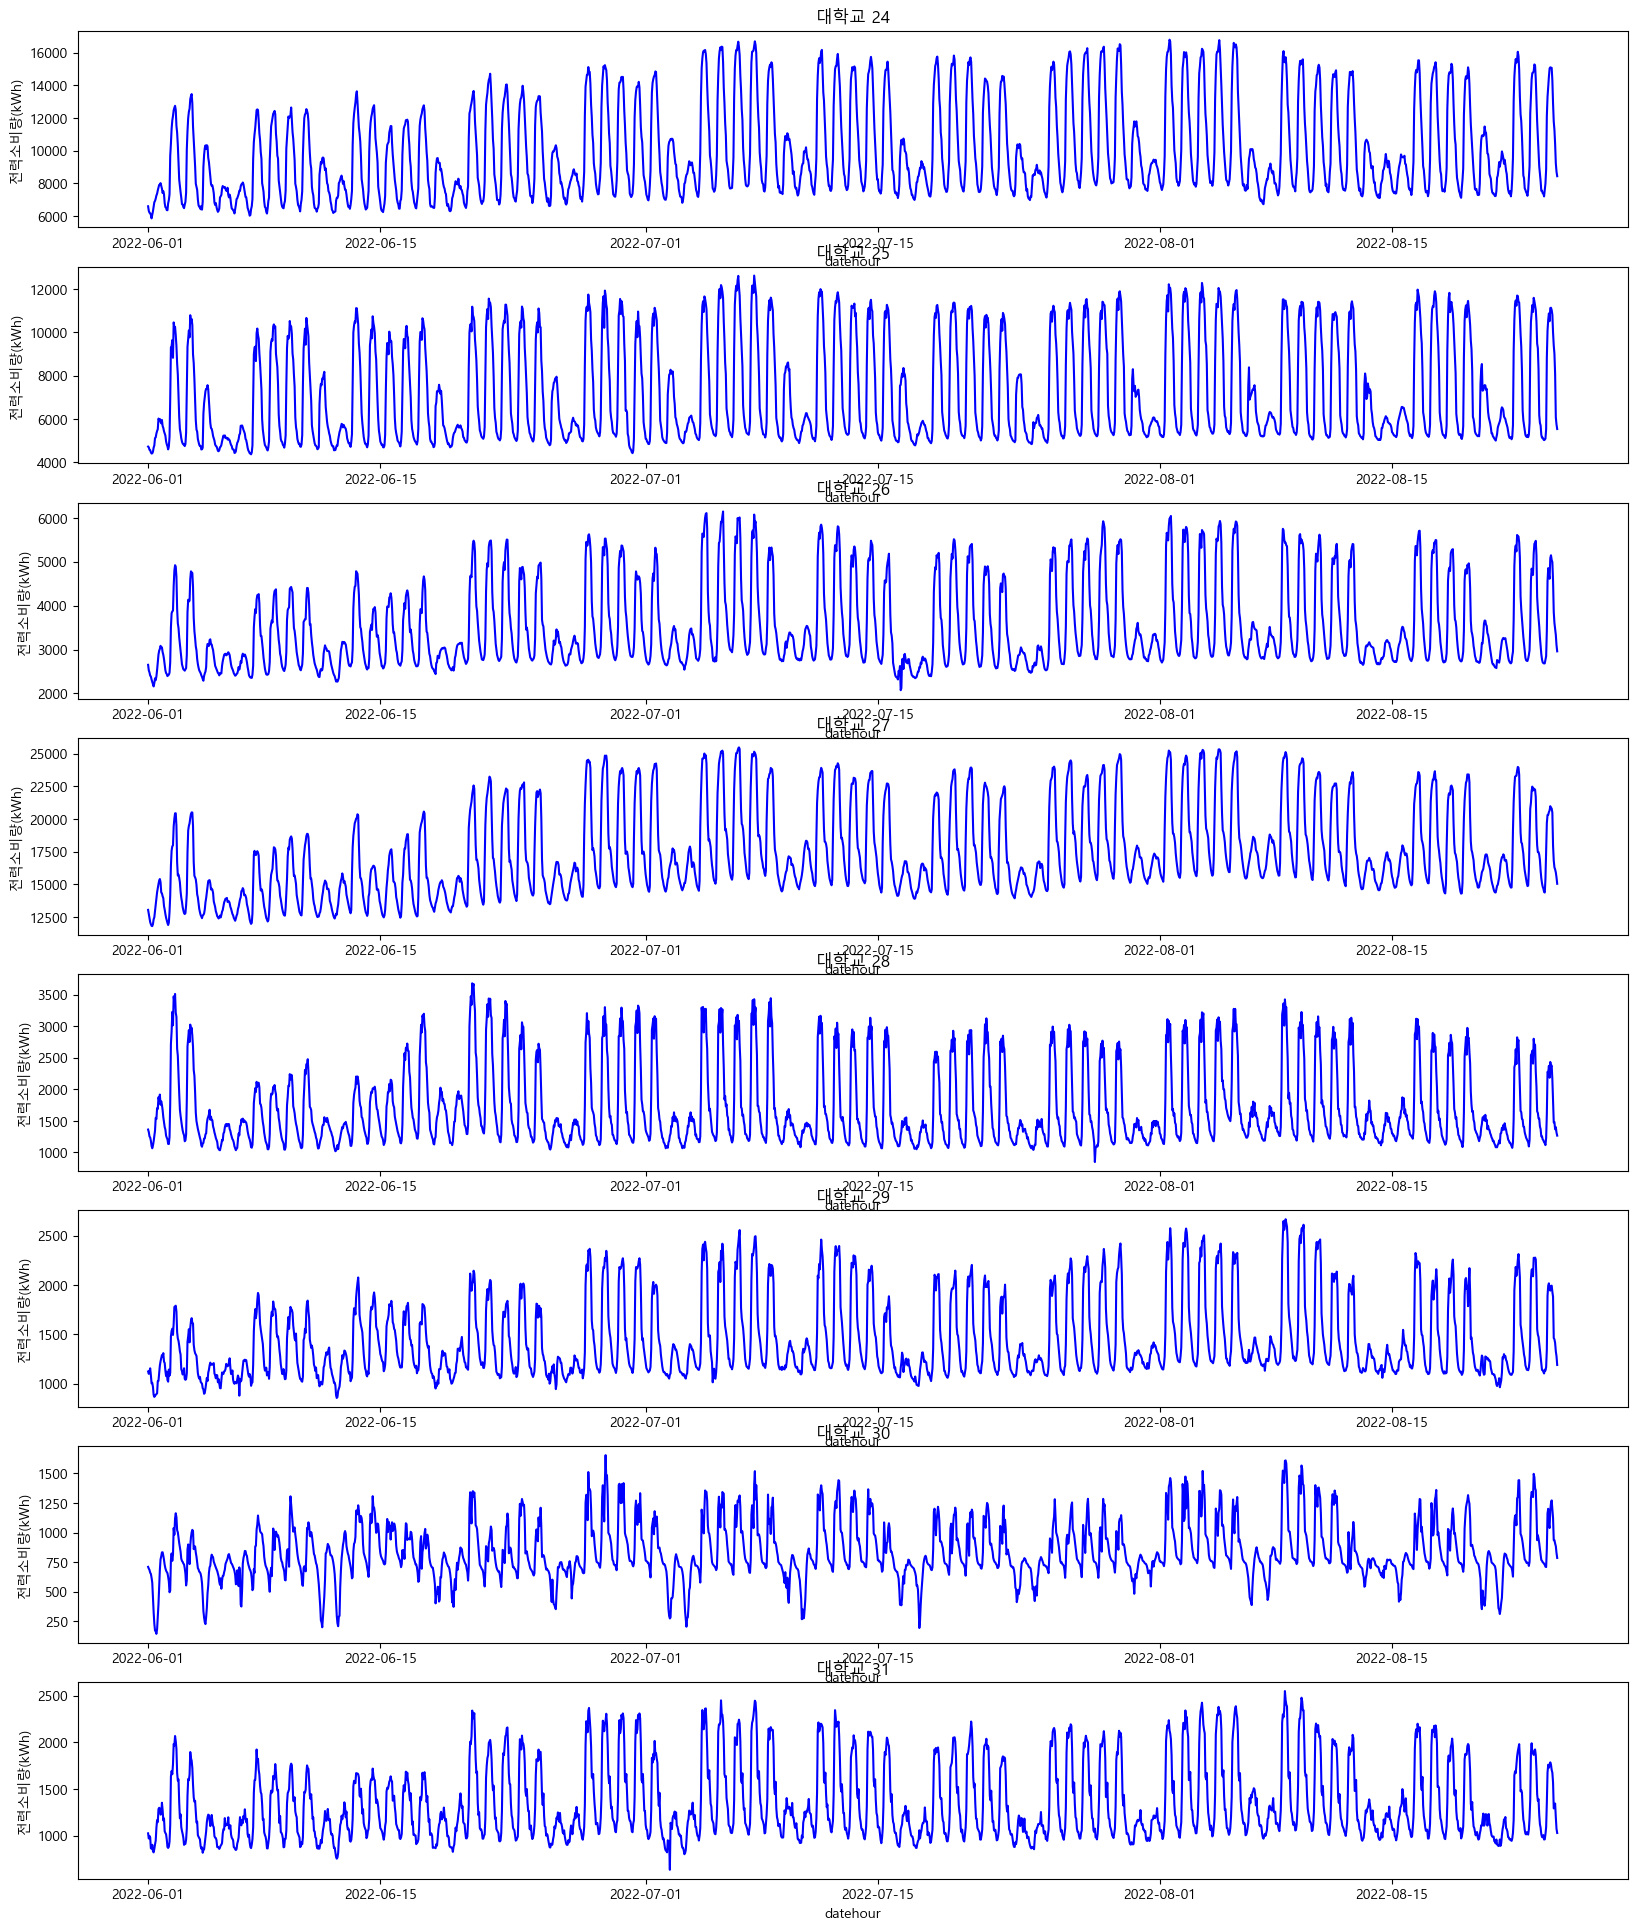

In [16]:
graph_by_btypes('대학교')

### 데이터센터

- 일별 전력소비량 최대값이 기온/불쾌지수의 일별 평균/최대값 추세를 따름
- 각 건물 별로 전력소비량의 최소값 최대값의 차이가 크지 않음 (편차가 작음)

- 이상치
    - 34/35번 건물
        - 8월 8일 위아래로 튀는 데이터 부자연스러워 보임 (어떤 이벤트가 발생한듯)

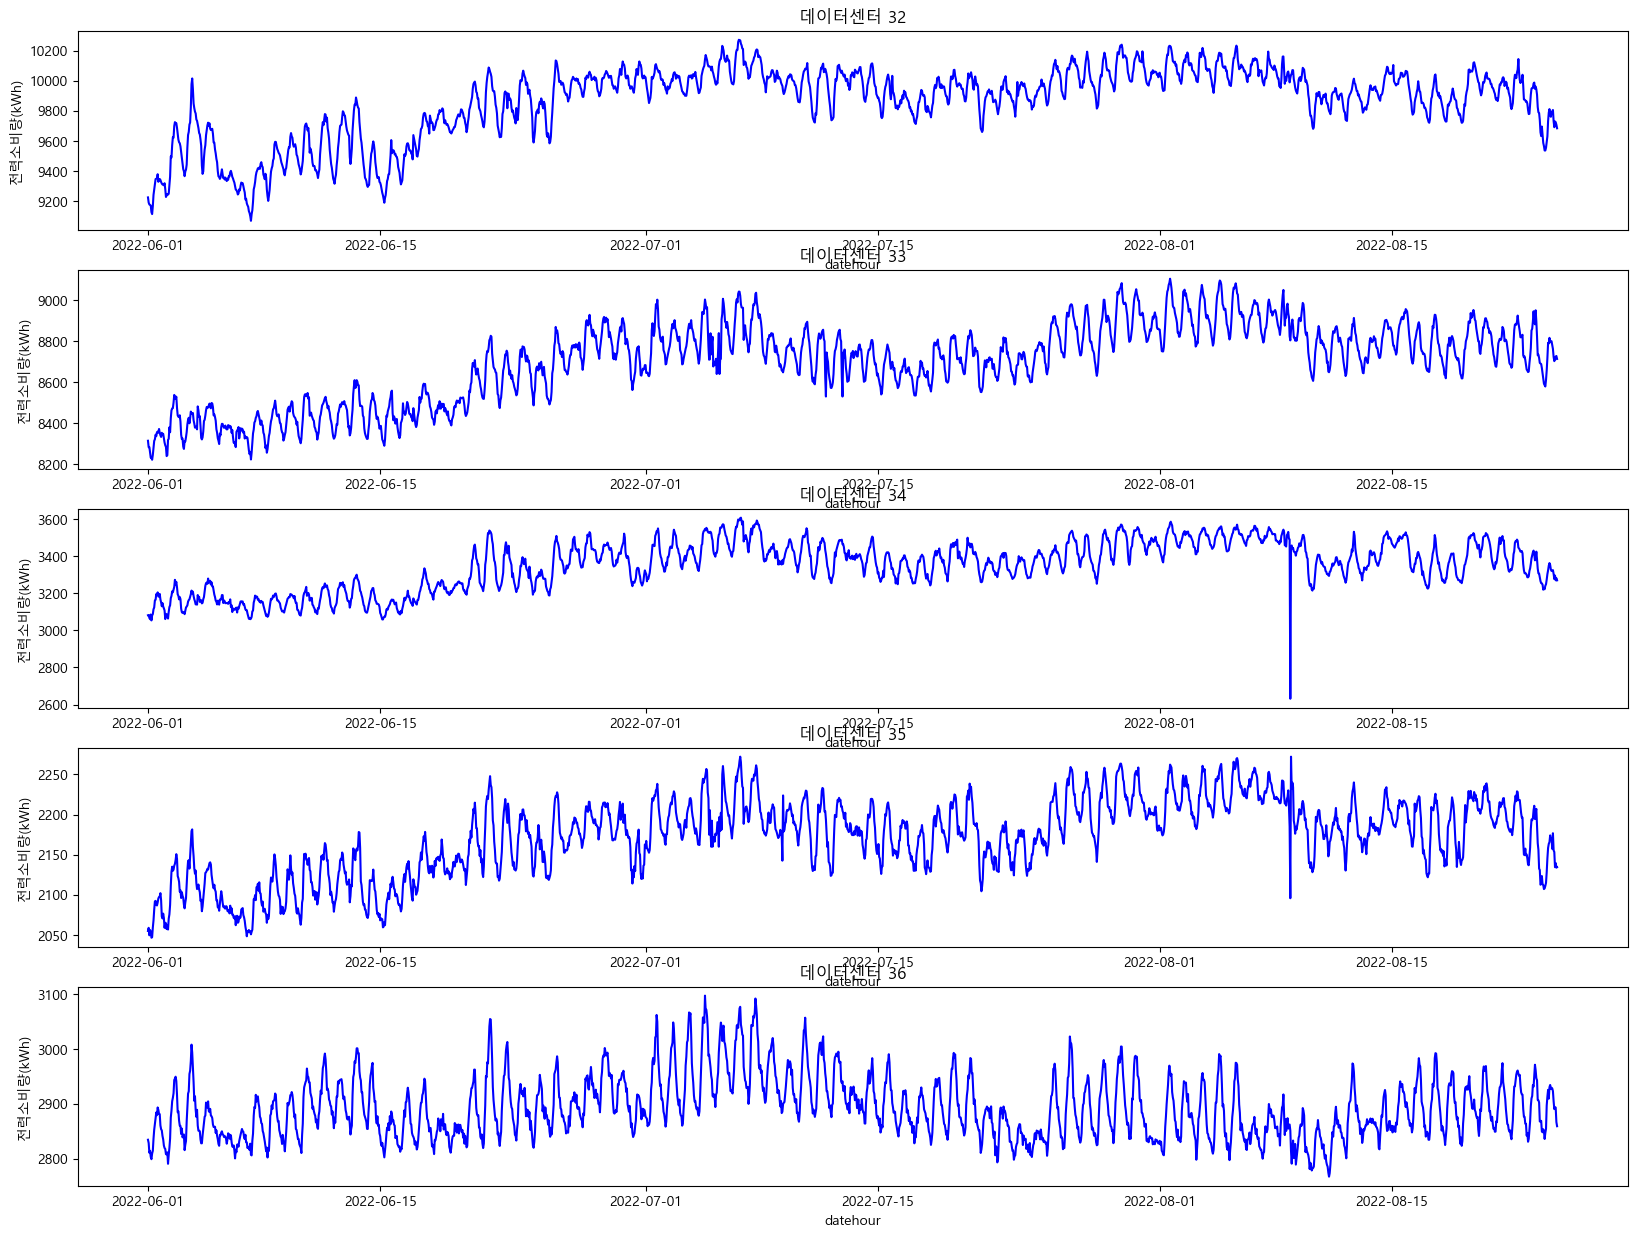

In [17]:
graph_by_btypes('데이터센터')

### 백화점 및 아울렛

- 일별 전력소비량 최대값이 기온/불쾌지수의 일별 평균/최대값 추세를 어느정도 따르는 것으로 보임
- 월요일 랜덤하게 휴무 또는 축소 영업하는 것으로 보임 (43/44번 건물 제외)
- 43/44번 건물
    - 두 건물의 전력소비량 패턴이 서로 쌍둥이처럼 비슷함
    - 주말에 전력소비량이 늘어나는 경향을 보임

- 이상치
    - 40번 건물
        - 6월 17일 금요일 축소영업 또는 휴무로 보임

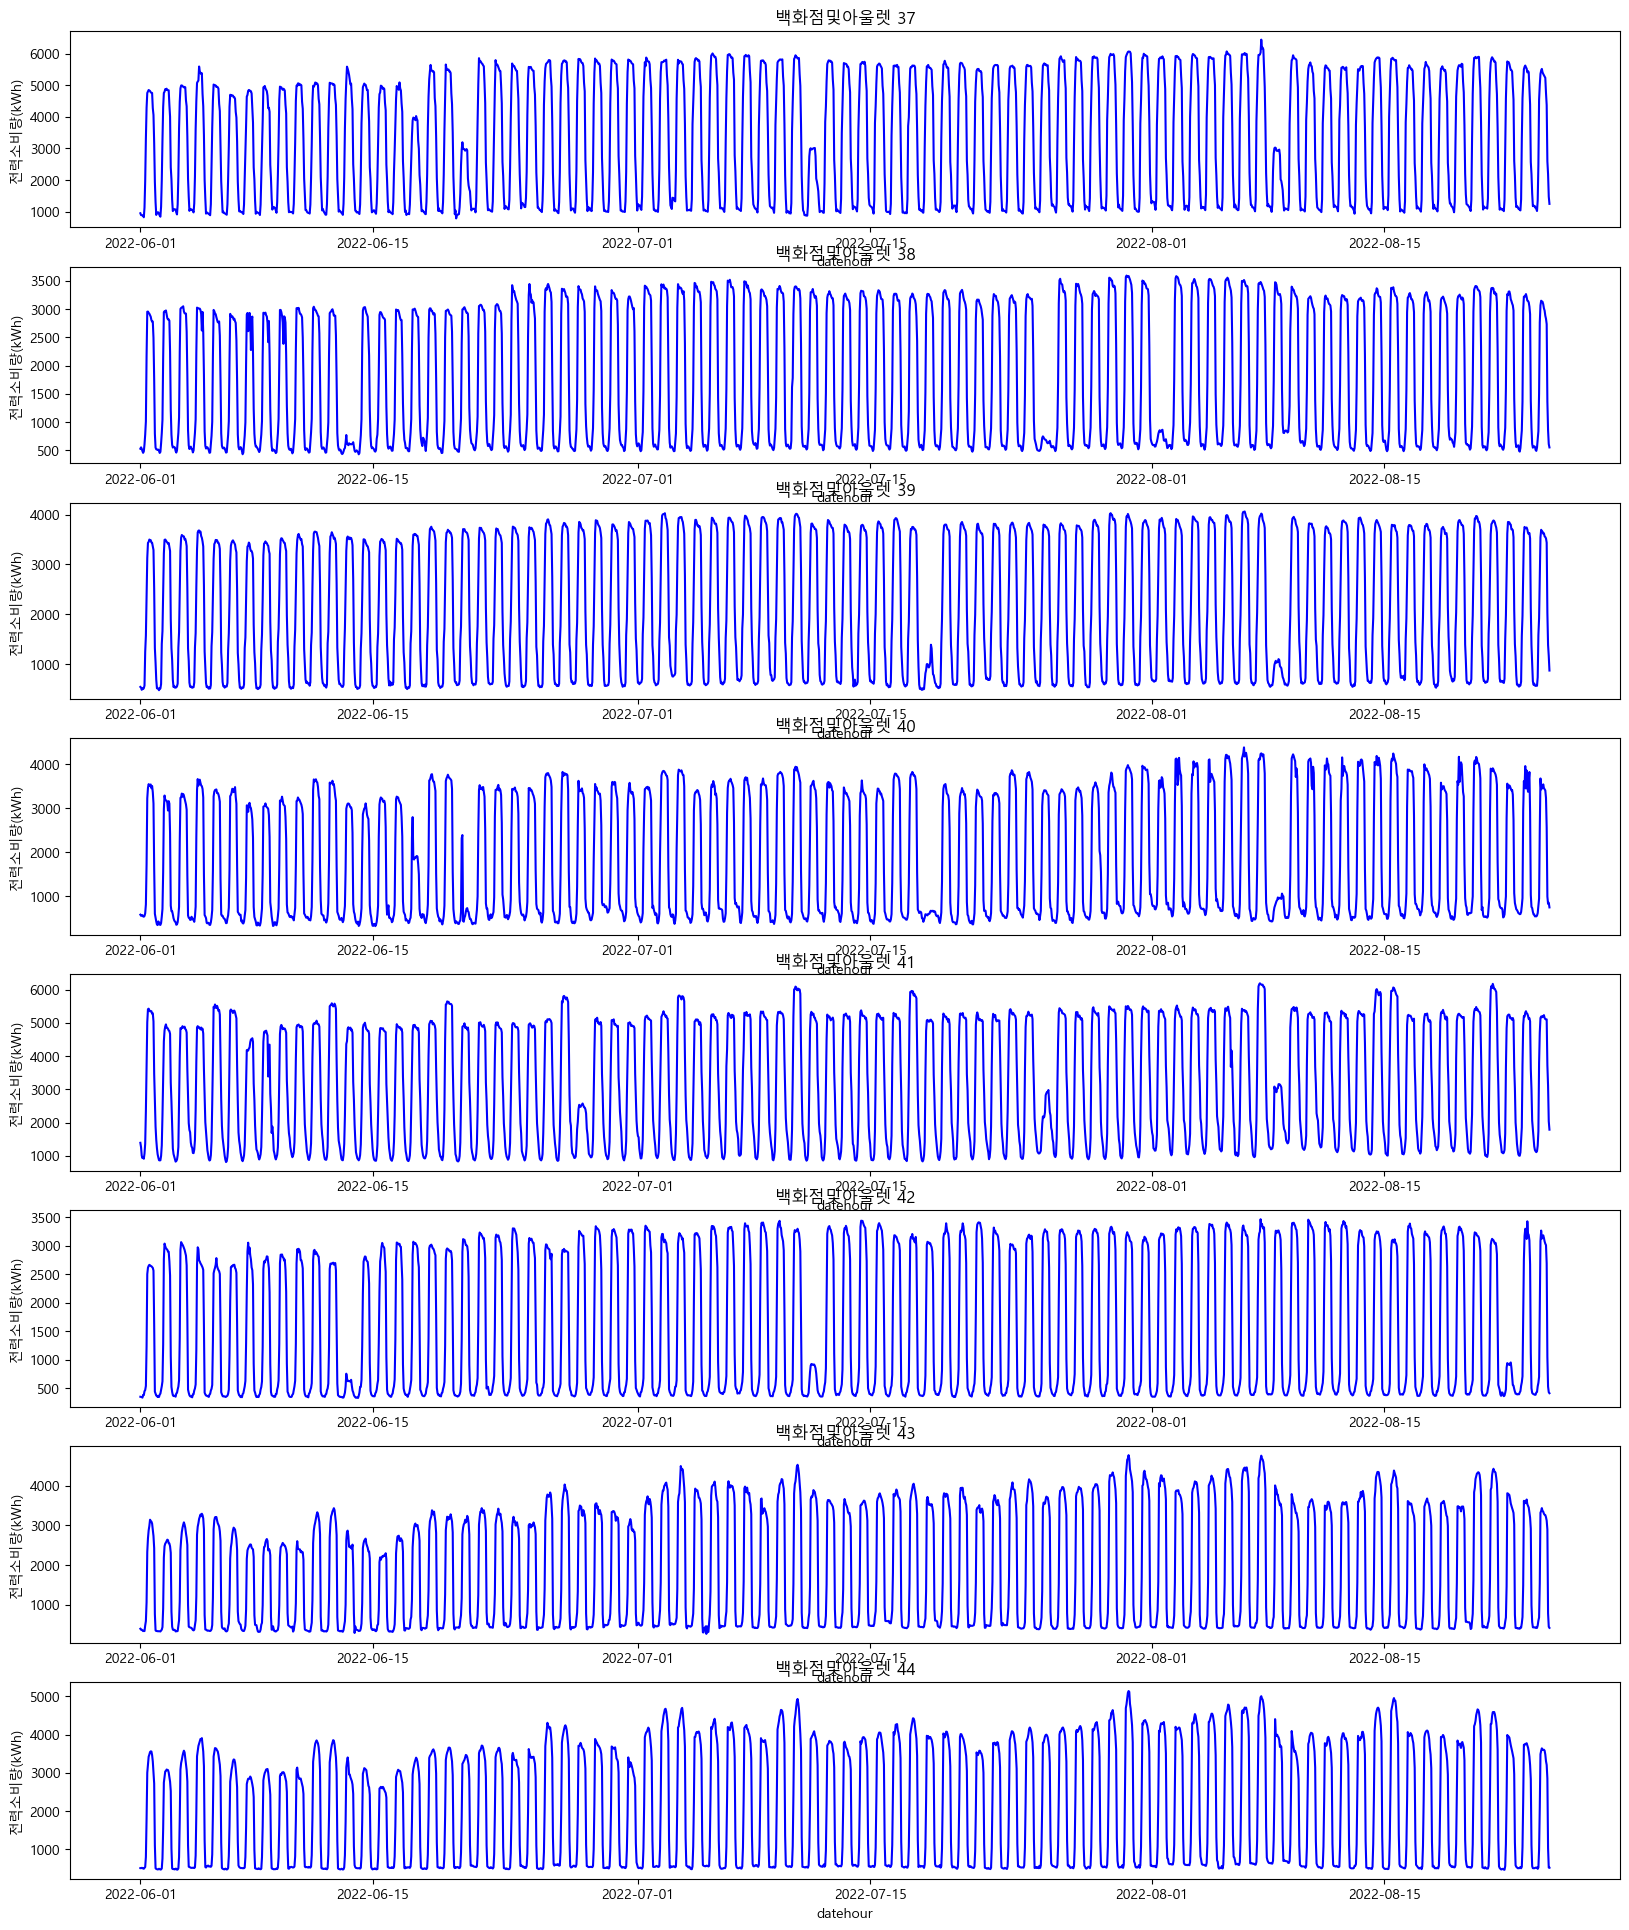

In [18]:
graph_by_btypes('백화점및아울렛')

### 상용

- 공휴일(holiday)에 전력소비량이 눈에 띄게 낮아짐 (54번 제외)
- 일별 전력소비량 최대값이 기온/불쾌지수의 일별 평균/최대값 추세를 어느정도 따름
- 54번 건물
    - 매주 월요일 전력소비량 낮은 경향 보임

- 이상치
    - 56번 건물
        - 6월 8일 비정상적으로 아래로 많이 튀는 데이터 존재
    - 58번 건물
        - 7월 5일 전력소비량만 아래로 축 쳐저있음

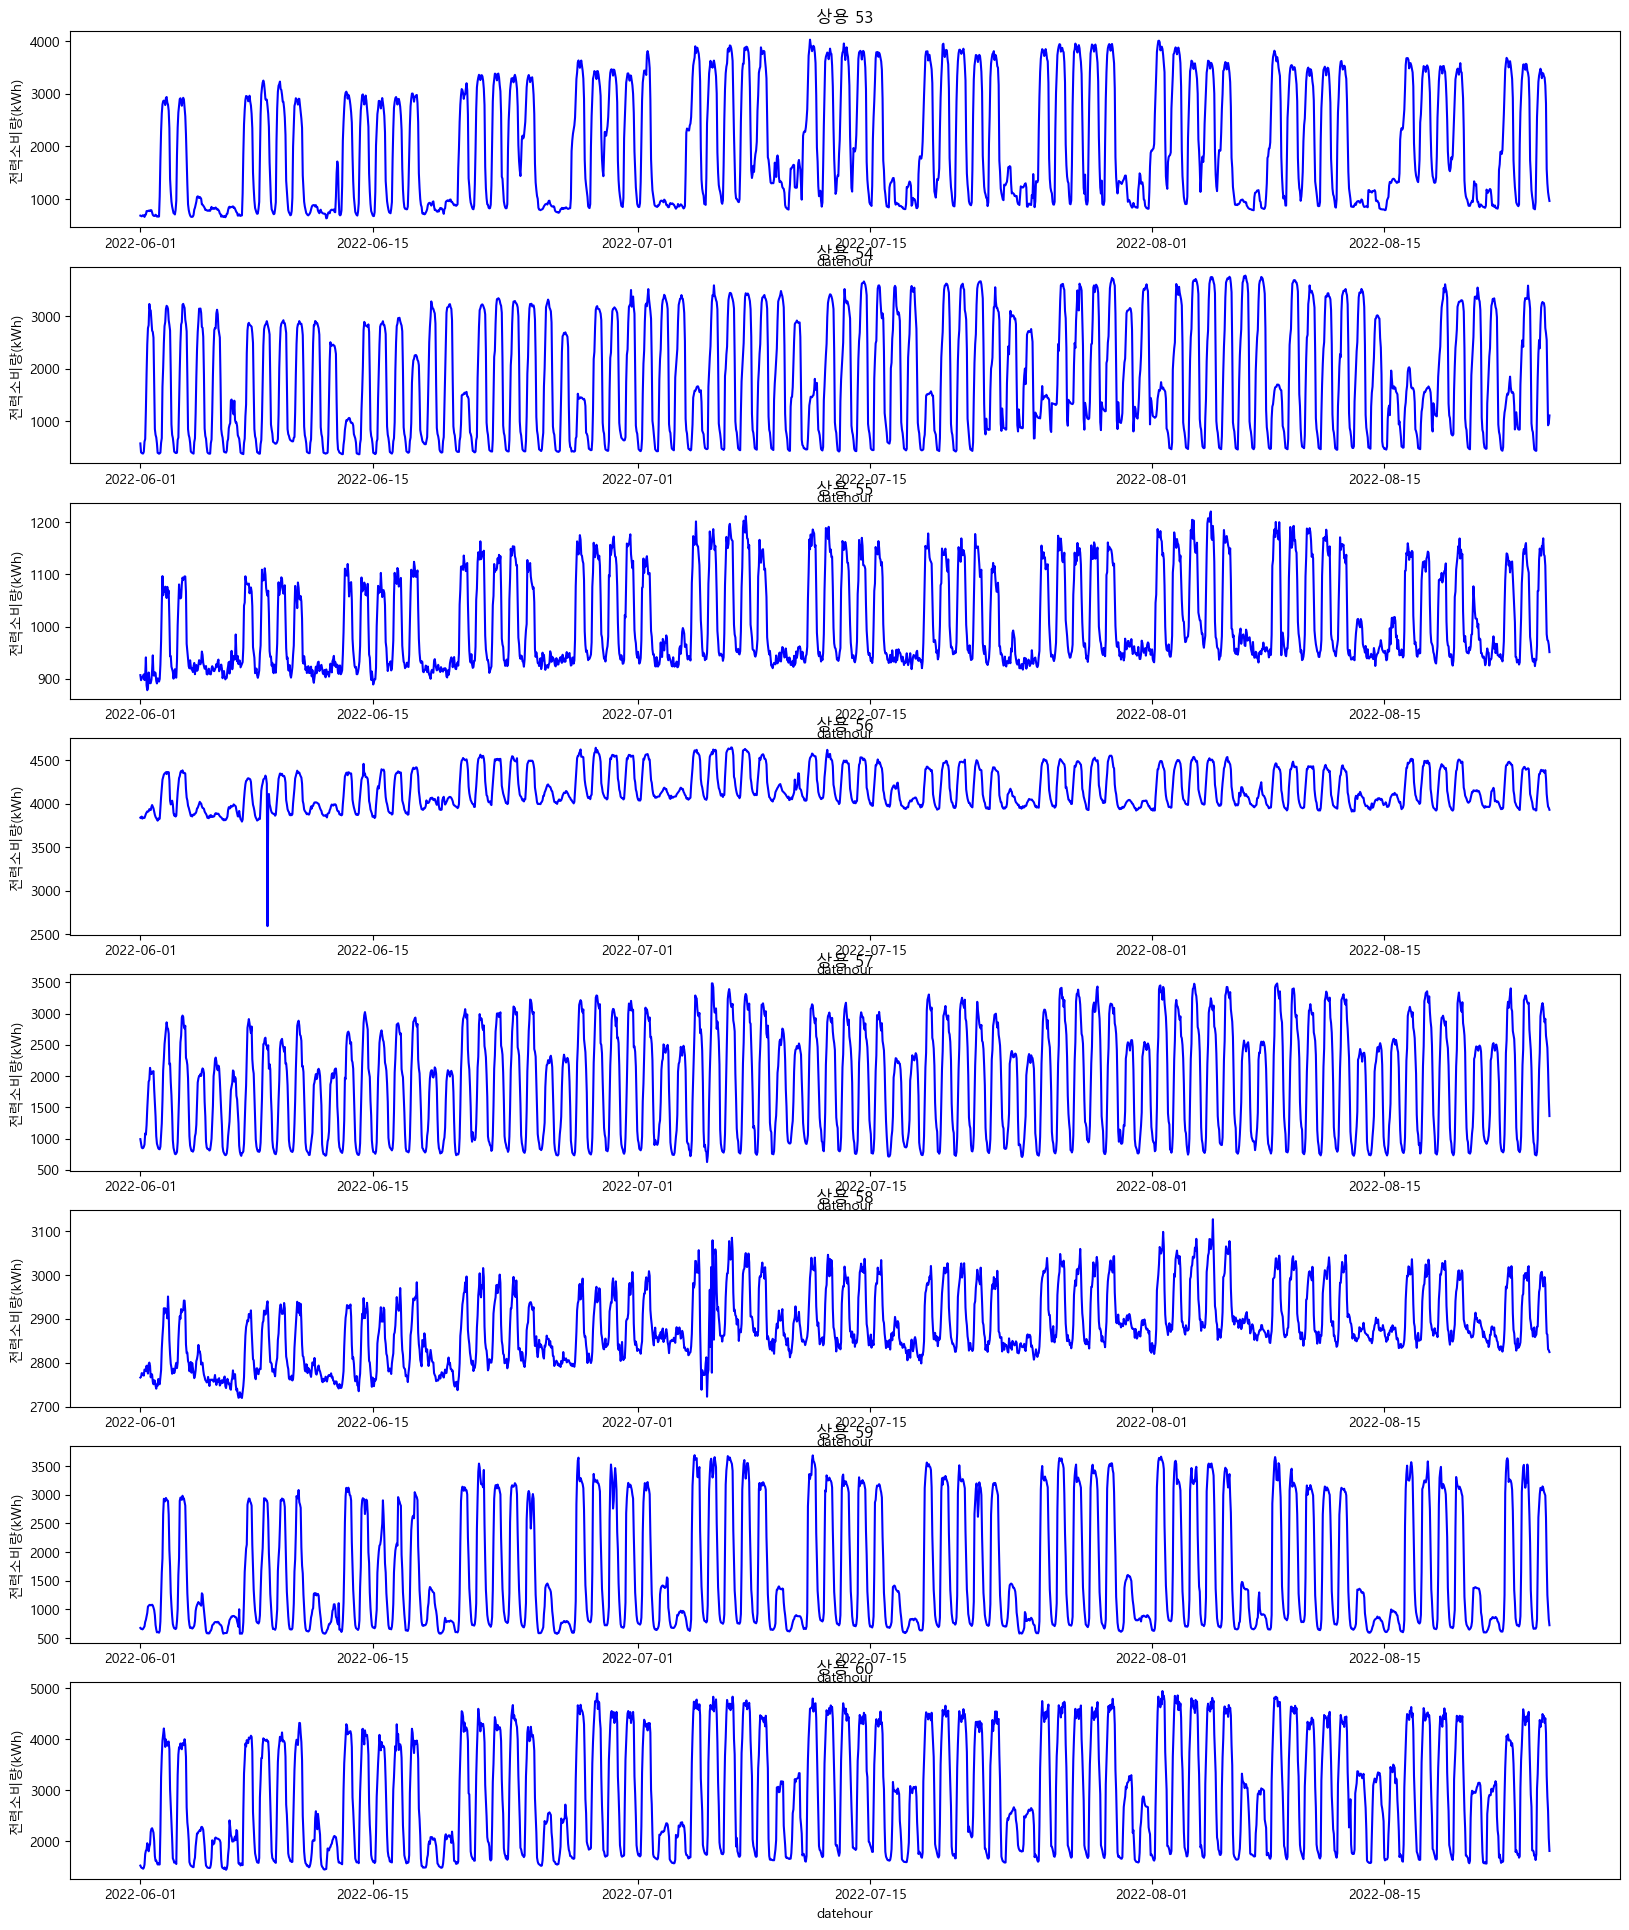

In [19]:
graph_by_btypes('상용')

### 아파트

- (새벽+오전)과 (오후) 시간대의 전력소비량 패턴 차이가 있음
    - 출퇴근 때문인 것으로 추측
- 공휴일(holiday)에는 (새벽+오전) 시간대의 전력소비량이 조금 더 상승
    - 주말엔 출근하지 않을 확률이 높기 때문인 것으로 추측
- 일별 전력소비량 최대값이 기온/불쾌지수의 일별 평균/최대값 추세를 어느정도 따름

- 이상치
    - 61번 건물
        - 7월 1일 전력소비량 아래로 튀는 곳 존재

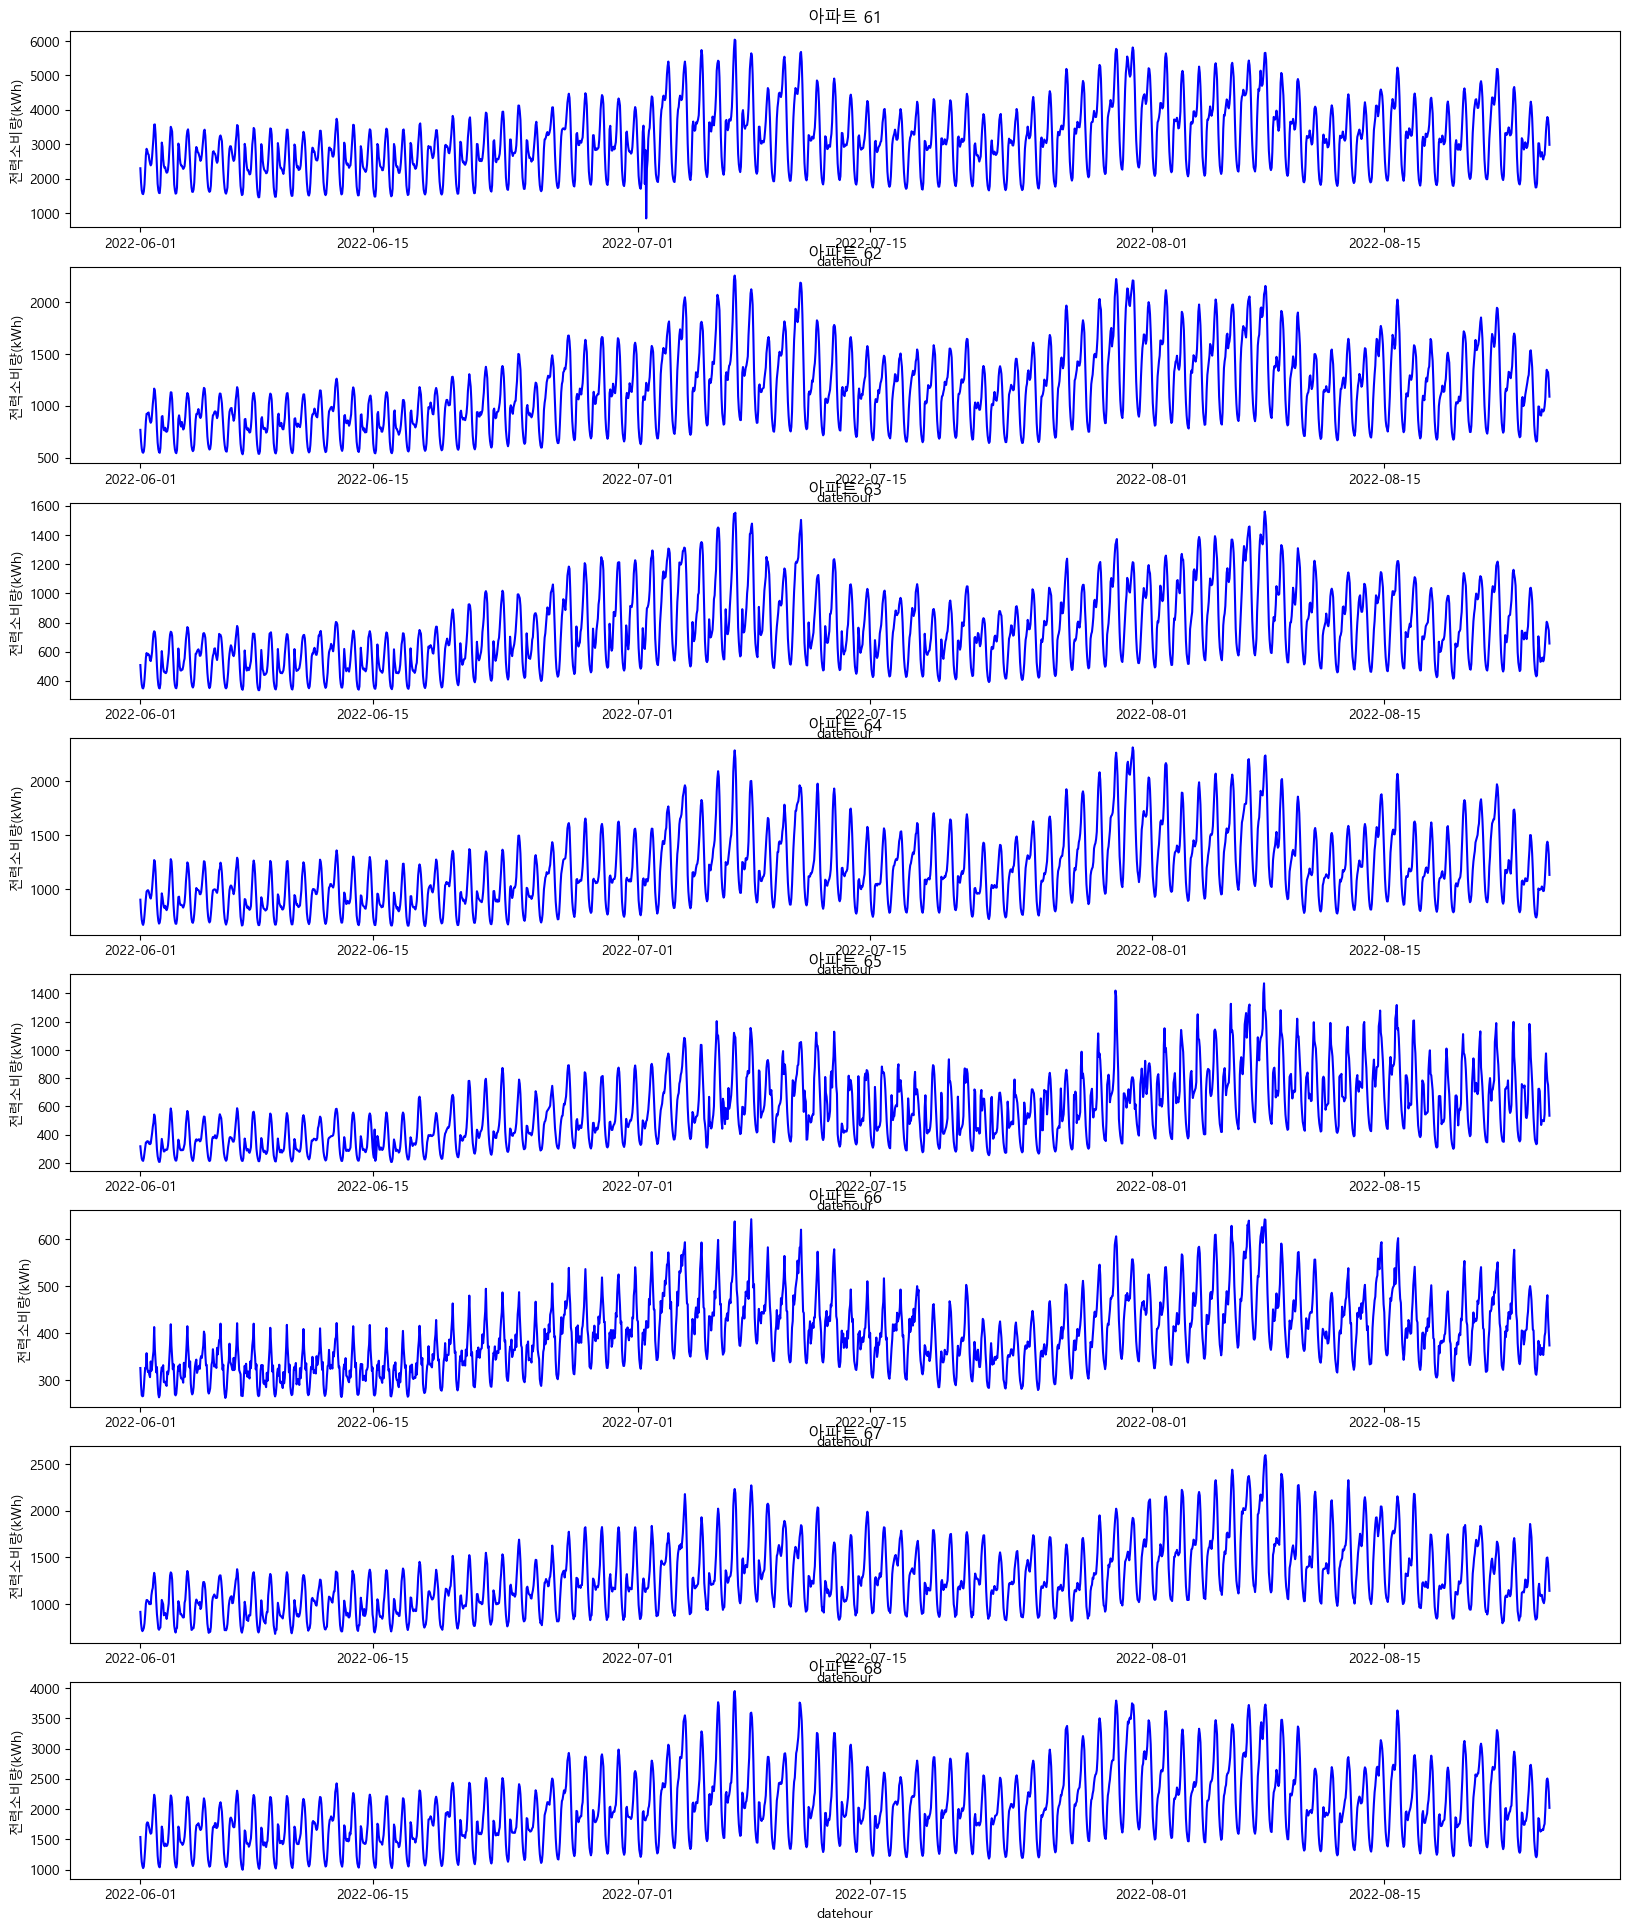

In [21]:
graph_by_btypes('아파트')

### 연구소

- 공휴일(holiday)에 전력소비량이 눈에 띄게 낮아짐 (54번 제외)
- 건물 별로 상당히 다른 모양의 전력소비량 패턴을 보임
    - 건물들을 클러스터링으로 분류해서 결과 확인해보면 좋을듯

- 이상치
    - 72/75번 건물
        - 아래로 갑작스럽게 튀는 데이터들 관찰됨

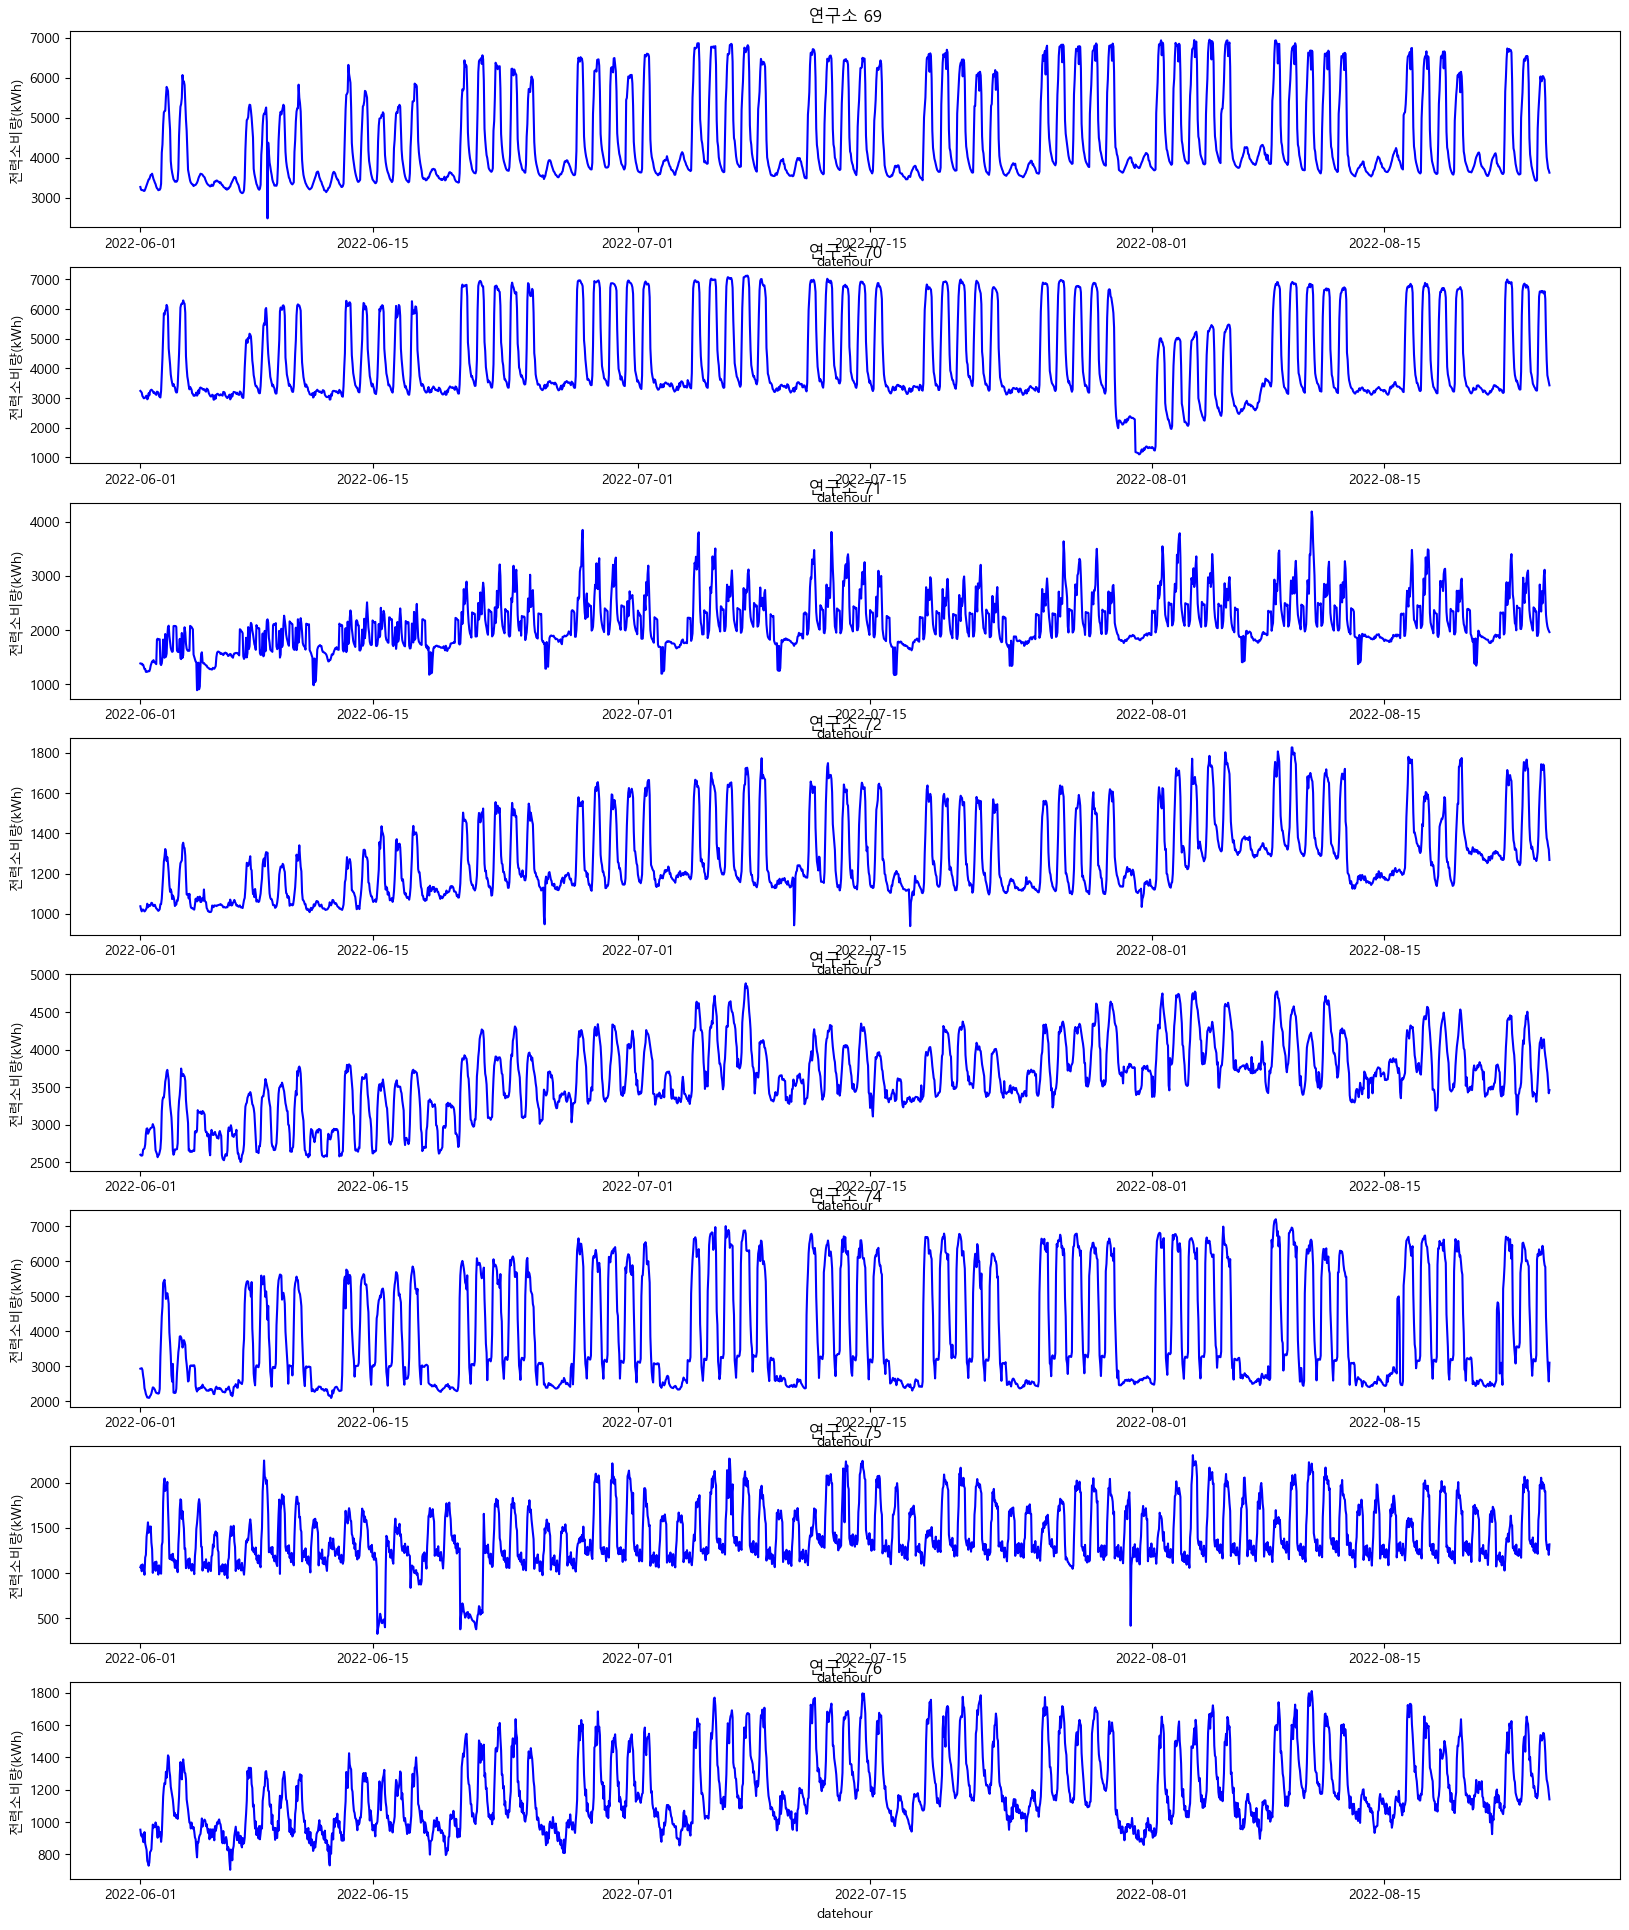

In [22]:
graph_by_btypes('연구소')

### 지식산업센터

- 공휴일(holiday)에 전력소비량이 눈에 띄게 낮아짐 (81번 제외)
    - 81번 건물은 공휴일에 더 높아지는 경향을 보임
- 일별 전력소비량 최대값이 기온/불쾌지수의 일별 평균/최대값 추세를 어느정도 따름

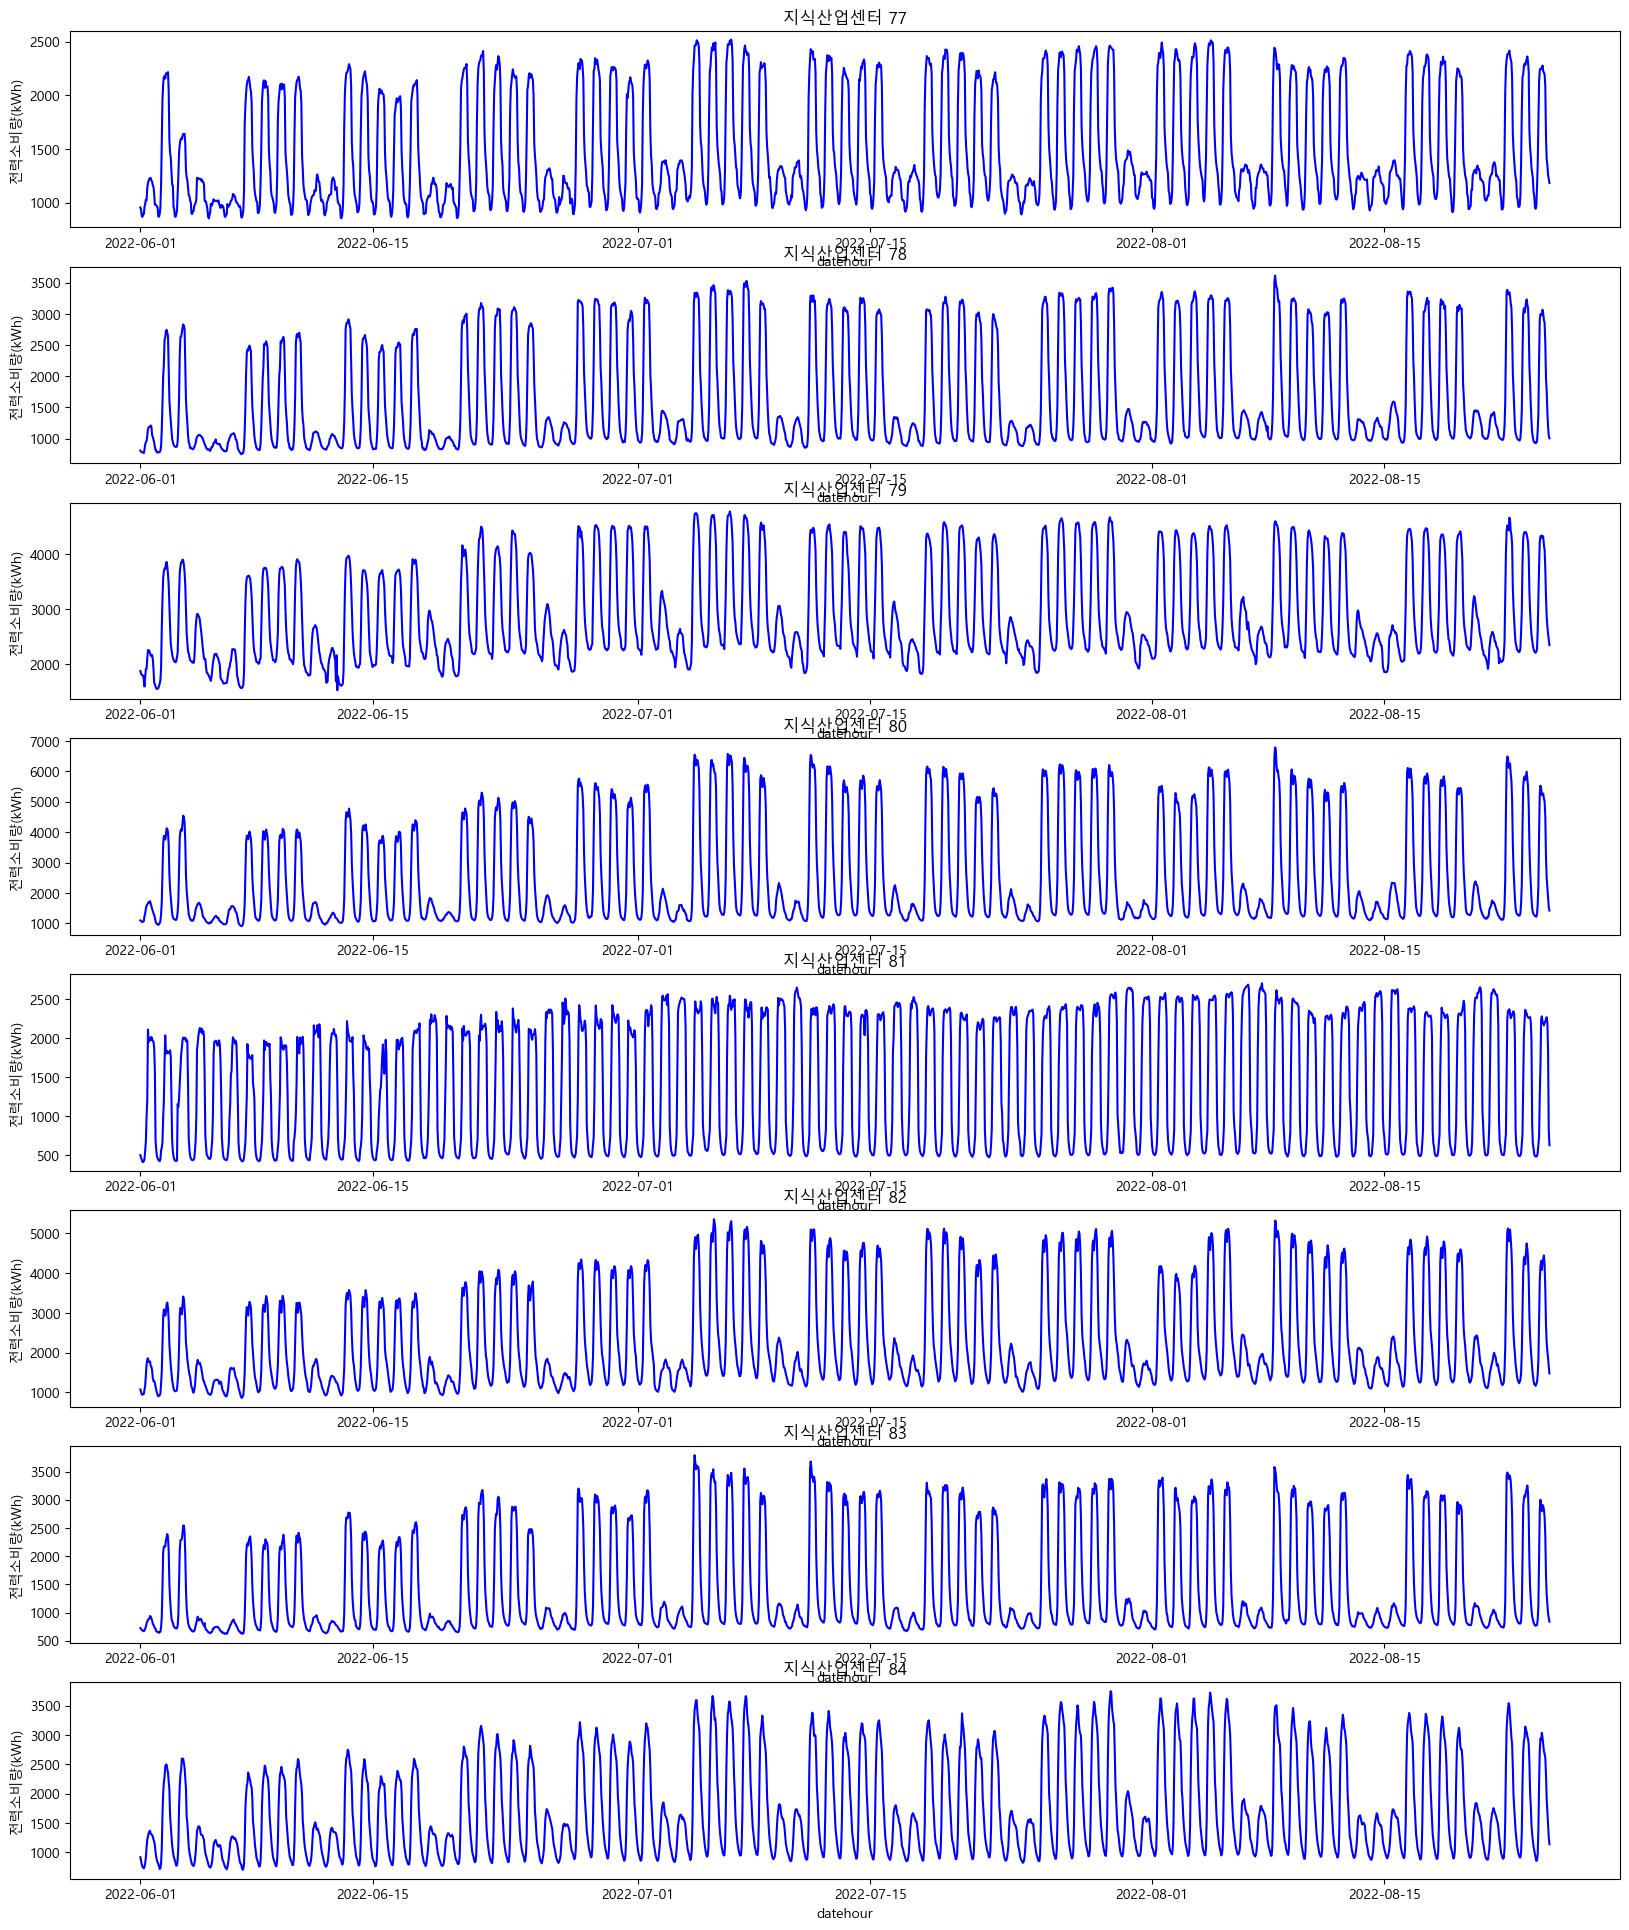

In [23]:
graph_by_btypes('지식산업센터')

### 할인마트

- 매월 2,4번째주 일요일 휴무하는 것으로 보임 (85번 제외)
    - test 데이터의 8월 29일에도 휴무할 것이라고 추측됨
- 일별 전력소비량 최대값이 기온/불쾌지수의 일별 평균/최대값 추세를 어느정도 따름

- 이상치
    - 86번 건물
        - 8월 14일 일요일 대신, 8월 10일 수요일에 쉰 듯

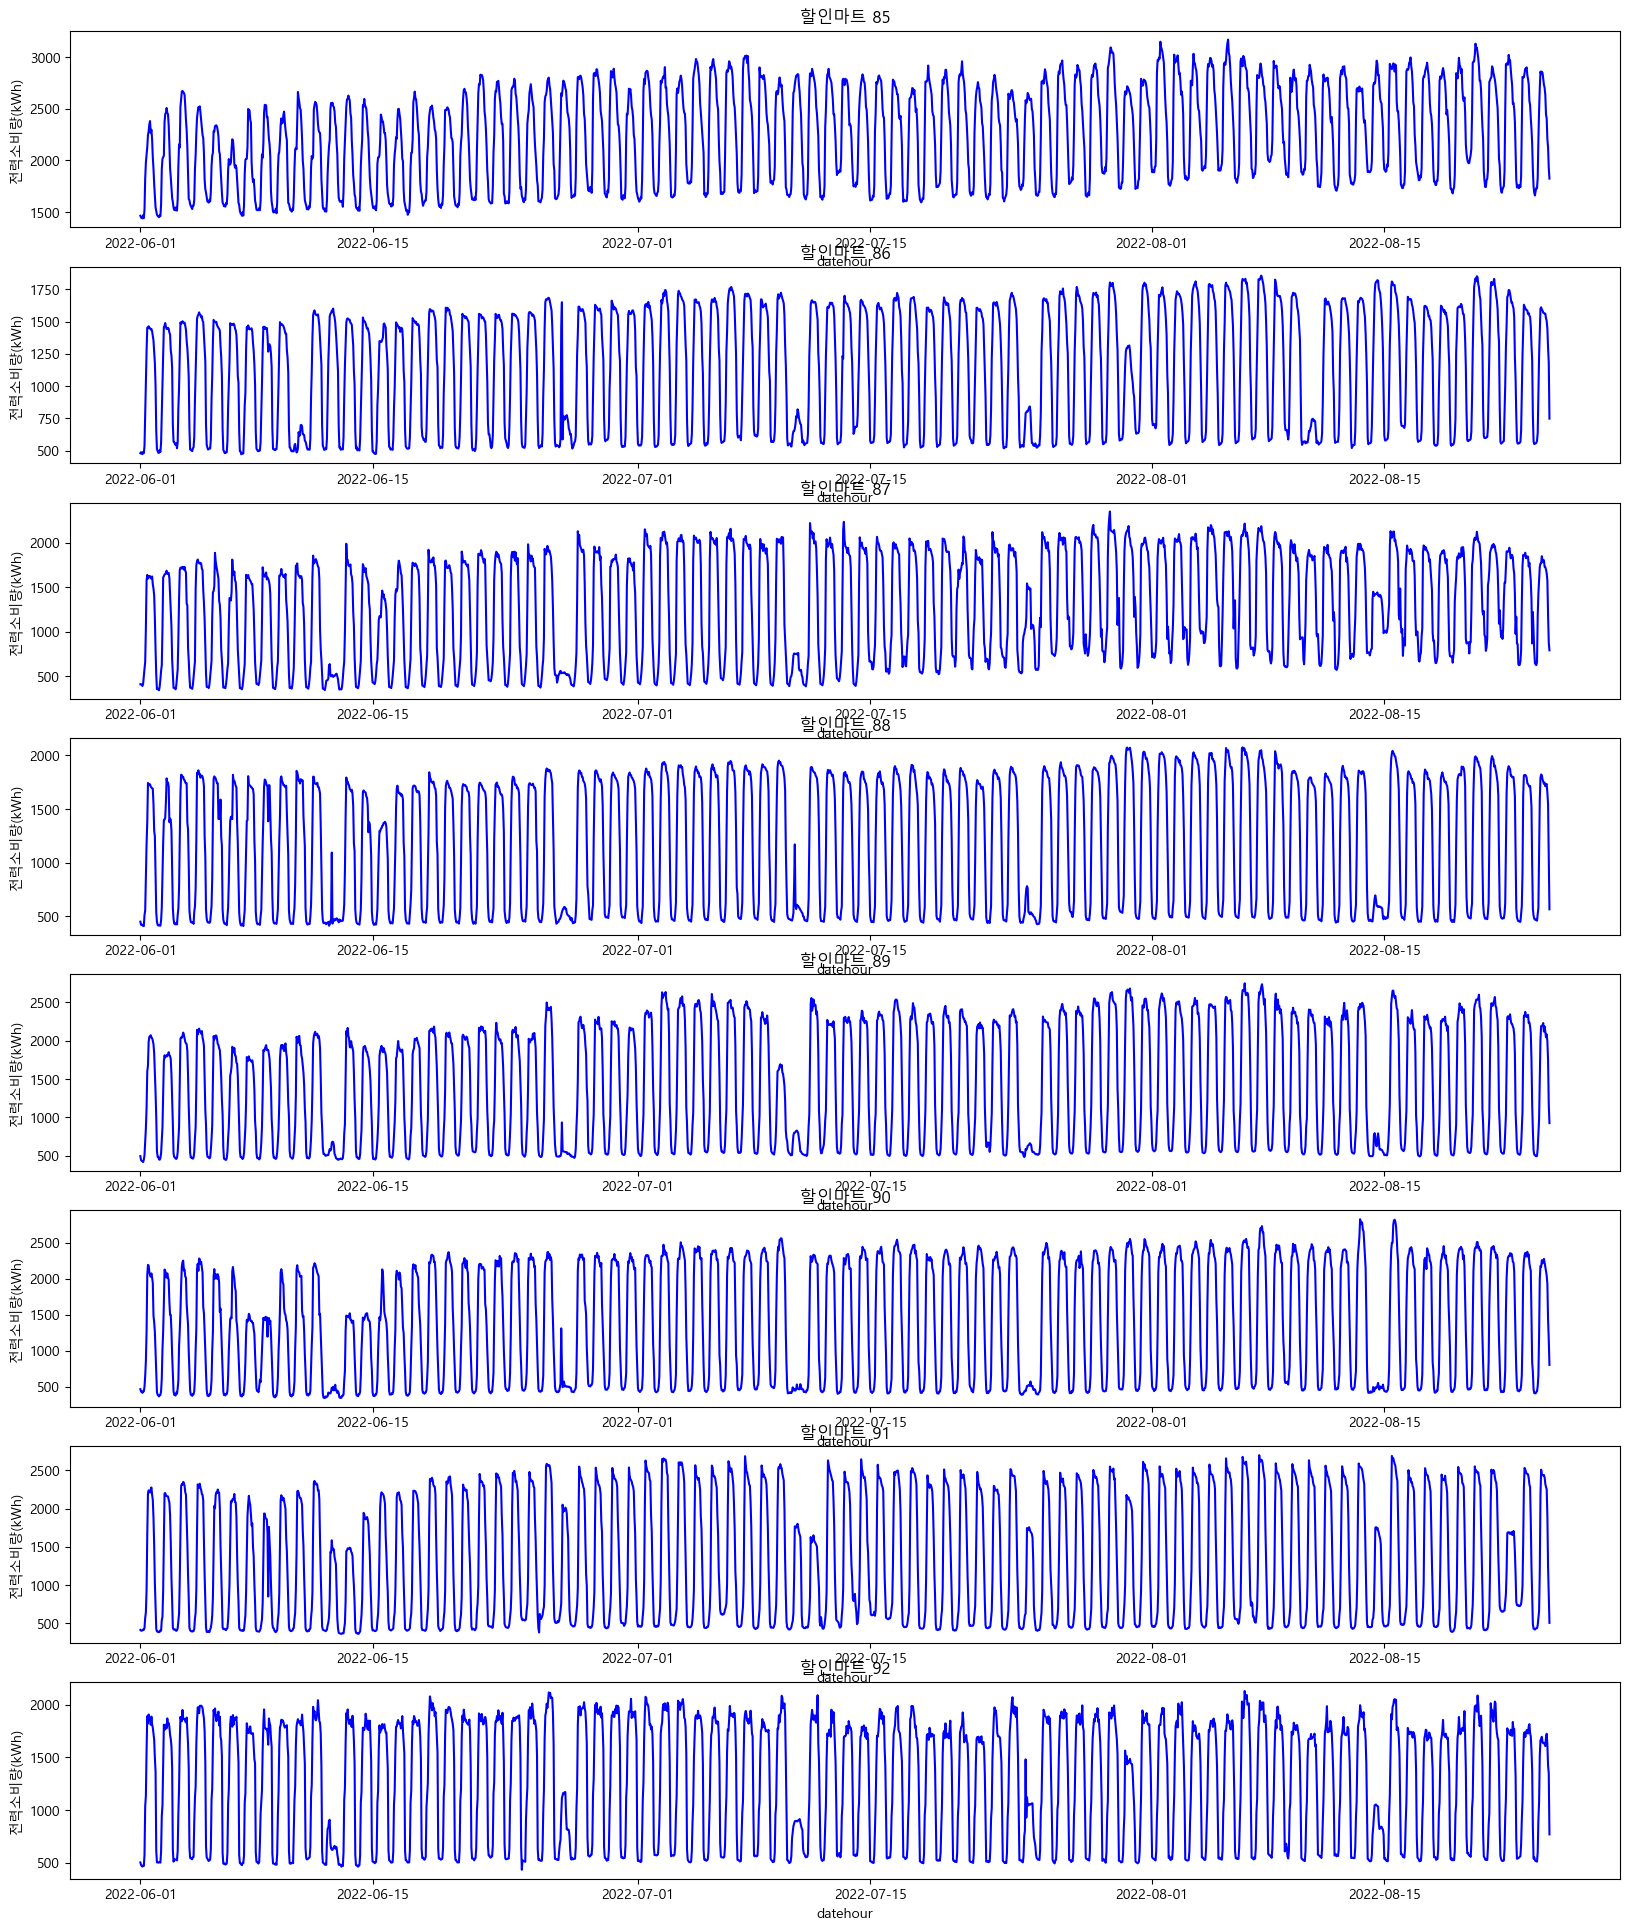

In [24]:
graph_by_btypes('할인마트')

### 호텔및리조트

- 일별 전력소비량 최대값이 기온/불쾌지수의 일별 평균/최대값 추세를 어느정도 따름

- 이상치
    - 95번 건물
        - 아래로 튀는 데이터 처리 필요해보임

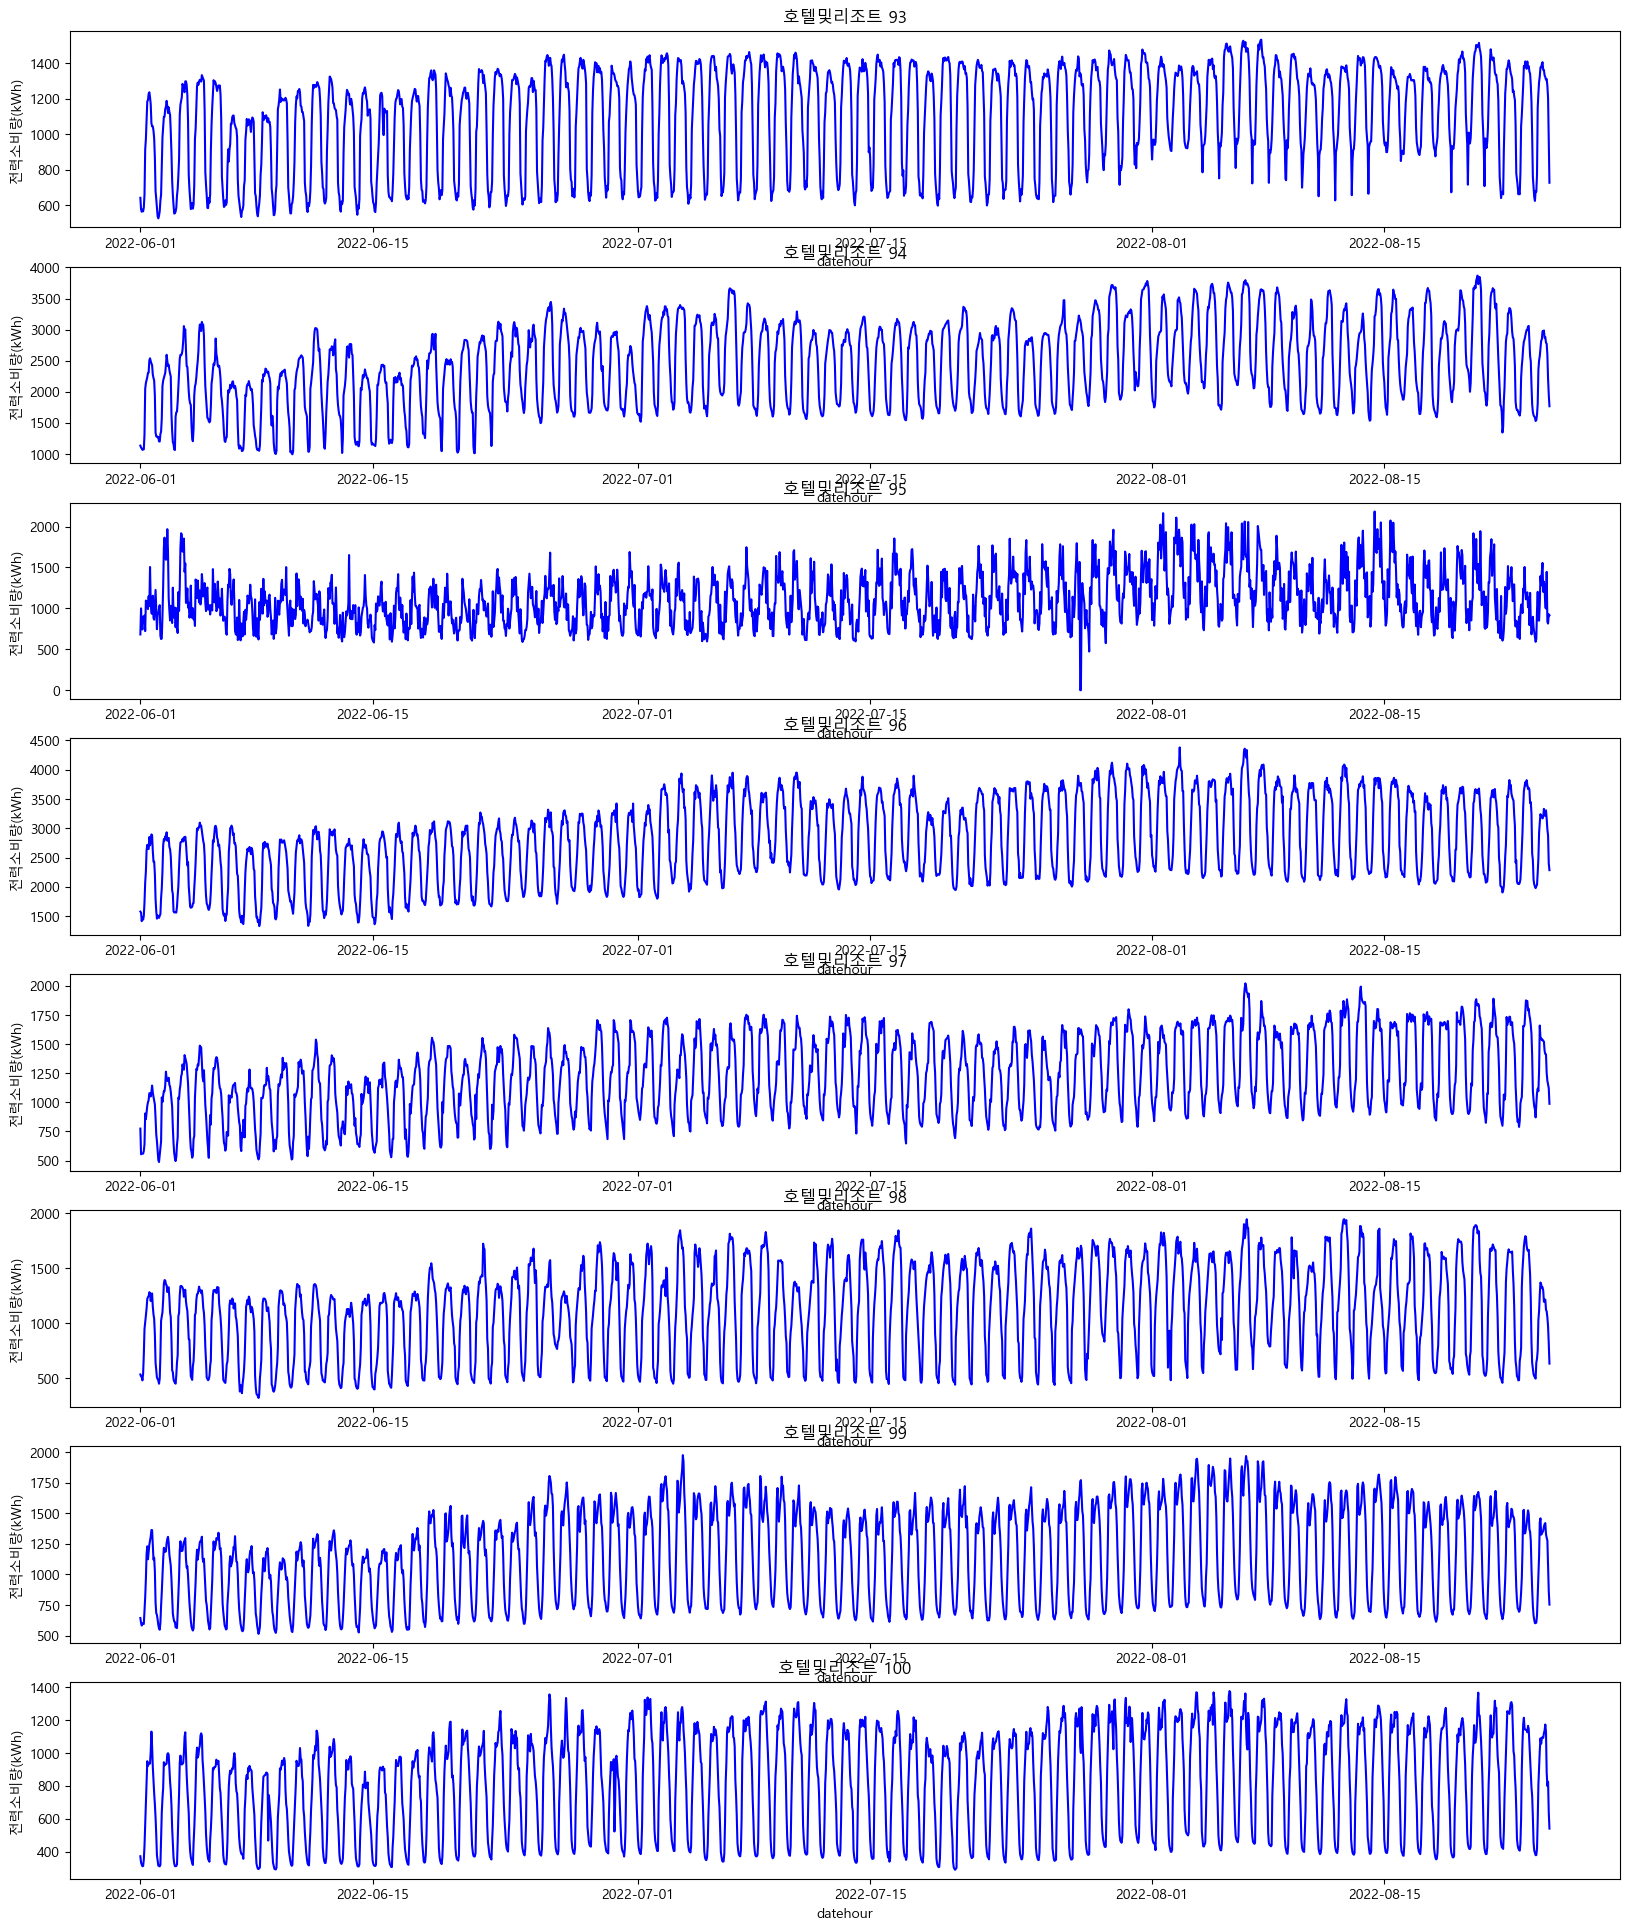

In [25]:
graph_by_btypes('호텔및리조트')